In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import re
import torch
import numpy as np
from code_15780 import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # optional, I use this for monitoring progress
from torch.nn import Module, Parameter, ModuleList
import torch.nn.functional as F

In [11]:
### Load the data with a tokenizer (tokenizing it twice, not that efficient)
tokenizer = SimpleTokenizer("pg100.txt", lowercase=False)
with open("pg100.txt", "rt",encoding="utf8") as f:
    content = f.read()

# for simplicity, force train/test to be an even multiple of seq_len
seq_len = 256
tokens = tokenizer.encode(content)
tokens_train = tokens[:int(len(tokens)*0.7)]
tokens_train = tokens_train[:(len(tokens_train)//seq_len)*seq_len]

tokens_val = tokens[int(len(tokens)*0.7):]
tokens_val = tokens_val[:(len(tokens_val)//seq_len)*seq_len]

In [12]:
class TransformerBlockPreNorm(Module):
    """ Single transformer block with attention plus a feedforward network"""
    def __init__(self, d,heads,d_ff):
        super().__init__()
        self.attn=SelfAttention(d, heads)
        self.w1=Linear(d,d_ff)
        self.w2=Linear(d_ff,d)

        self.norm1=LayerNorm(d)
        self.norm2=LayerNorm(d)

        self.relu=ReLU()

    def forward(self,X,mask=None):
        Z=X+self.attn(self.norm1(X))
        Y=Z+self.w2(self.relu(self.w1(self.norm2(Z))))
        return Y


In [13]:
layerList=[]
for i in range(2):
    layerList.append(TransformerBlockPreNorm(128,8,1024))
layerList
#a=[TransformerBlockPreNorm(128,8,1024) for _ in range(2)]
#a
total_batches=tokens_train.shape[0]//seq_len
t=tokens_train.reshape(total_batches,seq_len)
t=t[:((t.shape[0]//5)*5),:]
t.shape
# t.shape

#a==layerList

torch.Size([3980, 256])

In [14]:
class LanguageModel(Module):
    """ Complete language model that runs:
        - Embedding
        - Positional Encoding
        - Tranformer block layers
        - Output linear layer
    """
    def __init__(self, hidden_dim,seq_len,heads,ffn_dim,num_layers,vocab_size):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embed= Embedding(vocab_size, hidden_dim)
        self.position = PositionalEncoding(hidden_dim)
        layerList=[]
        for i in range(num_layers):
            layerList.append(TransformerBlockPreNorm(hidden_dim,heads,ffn_dim))
        self.layers=ModuleList(layerList)
        self.norm=LayerNorm(hidden_dim)

        self.last_layer=Linear(hidden_dim, vocab_size)

    def forward(self,X):
        B,T=X.shape[0],X.shape[1]
        
        X_hidden=torch.zeros(B,T,self.hidden_dim)
        for i in range(B):
            X_hidden[i] = self.embed(X[i])
        
        X_hidden = self.position(X_hidden)
        

        mask=torch.tril(torch.ones(T,T))
        mask=mask.masked_fill(mask==0,float('-inf'))

        for layer in self.layers:
            X_hidden=layer(X_hidden,mask)
        
        #print((self.norm(X_hidden)).shape)
        return self.last_layer(self.norm(X_hidden))

        

In [15]:
def epoch_transformer_lm(model, tokens, seq_len, opt=None, batch_size=5, verbose=True):
    """ Run an epoch of the linear language model on the sequence of tokens.  
    If opt = None then just compute the loss, otherwise update the parameters
    using the optimizer.

    Args:
        model: torch.Module - PyTorch LanguageModel instance 
        tokens: torch.tensor (int64) - sequence of tokens to eval/train on
        seq_len: sequence length to evaluate in Transformer blocks
        batch_size: int - number of elements in minibatch
        verbose: bool - flag if you want to print debug info

    Returns:
        losses: torch.tensor (float) - losses on each minibatch
    """
    losses=[]
    big_batch=seq_len*batch_size
    num_batches=tokens.shape[0]//big_batch
    for i in range(num_batches):
        #print(set.shape,num_batches)
        t=tokens[i*big_batch:(i+1)*big_batch]
        t=t.reshape(batch_size,seq_len)
        X=t[:,0:seq_len-1]
        targets=t[:,1:seq_len]
        H=model(X)
        loss=F.cross_entropy(H.reshape(-1,H.size(-1)),targets.reshape(-1))
        losses.append(loss)
        if opt is not None:
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if verbose and i%10==0:
            print(f"Batch {i+1}/{num_batches},Loss: {loss.item()}")
    return losses

In [60]:
tokens_train.shape[0]//(5*seq_len)

796

In [22]:
model = LanguageModel(128, seq_len, 8, 1024, 5, tokenizer.vocab_size)
#opt = optim.Adam(model.parameters(), lr=1e-3)
#print(model.parameters)
#opt = SGD(model.parameters(), lr=0.5)
opt= Adam(model.parameters(),lr=1e-3)
sum(p.numel() for p in model.parameters())


9892554

In [25]:
model = LanguageModel(128, seq_len, 8, 1024, 5, tokenizer.vocab_size)
batch_size=5
X=tokens_train[:seq_len*batch_size]
X=X.reshape(batch_size,seq_len)
Y=model(X)
print(Y.shape)


torch.Size([5, 256, 32074])


In [23]:
losses = epoch_transformer_lm(model, tokens_train, 256, opt=opt, batch_size=5, verbose=True)
with torch.no_grad():
    val_losses = epoch_transformer_lm(model, tokens_val, 256)
print(torch.mean(torch.tensor(val_losses)))

Batch 1/796,Loss: 11.292793273925781
Batch 11/796,Loss: 7.695259094238281
Batch 21/796,Loss: 7.049825191497803
Batch 31/796,Loss: 6.132253646850586
Batch 41/796,Loss: 6.0013275146484375
Batch 51/796,Loss: 6.1434760093688965
Batch 61/796,Loss: 5.806197166442871
Batch 71/796,Loss: 5.356391906738281
Batch 81/796,Loss: 5.721742630004883
Batch 91/796,Loss: 6.06640625
Batch 101/796,Loss: 5.481235504150391
Batch 111/796,Loss: 5.843204498291016
Batch 121/796,Loss: 5.444056034088135
Batch 131/796,Loss: 5.747463226318359
Batch 141/796,Loss: 5.682422161102295
Batch 151/796,Loss: 5.179978370666504
Batch 161/796,Loss: 5.528894424438477
Batch 171/796,Loss: 5.773952484130859
Batch 181/796,Loss: 5.507490634918213
Batch 191/796,Loss: 5.693788528442383
Batch 201/796,Loss: 5.335220813751221
Batch 211/796,Loss: 6.349837779998779
Batch 221/796,Loss: 5.510002613067627
Batch 231/796,Loss: 5.3709001541137695
Batch 241/796,Loss: 5.685588836669922
Batch 251/796,Loss: 5.6994948387146
Batch 261/796,Loss: 5.306807

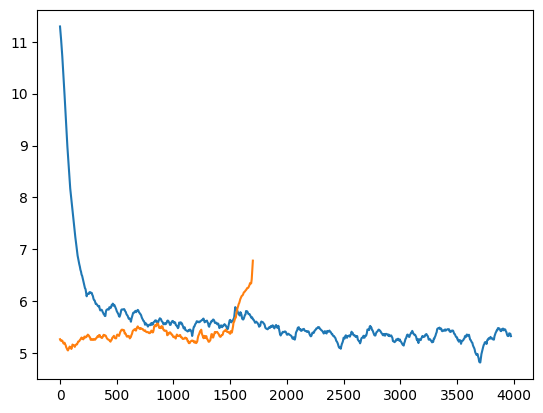

In [26]:
plt.plot(np.arange(0,len(losses)*batch_size,batch_size),ema(torch.tensor(losses), beta=0.9))
plt.plot(np.arange(0,len(val_losses)*batch_size,batch_size),ema(torch.tensor(val_losses), beta=0.9))